# About the data:

This data is meant to mimic a generic e-commerce dataset, not our business. This data was all generated by a script rather than actual users, but with some degree of thought to distributions and how it all fits together. We tried to keep everything that you'd look as a realistic approximation of real data, with all its challenges and inconsistencies. If you have questions about whether something that you're seeing is intentional or not, please ask us about it. In general, please assume that this data is from the company you work for, so you are free to make any assumptions you require as long as you explain your thought process.


# Questions

#### 1. Marketing Attribution

- a. What campaign was responsible for each user's finding our app?

Tips:

- Think about assumptions or data cleanup steps related to data inconsistencies, many to many mappings, or broken database schemas in the data. These may cause SQL joins to return incorrect results. Thinking about timestamps is useful here

- Please describe how you decided what attribution logic to use. How much time would you allow between the attribution and the user creation, and why ? For example, you can compare simple vs complex methods and discuss the pros and cons

 
#### 2. Low Sales

- It looks like sales have been a bit low the last couple of days of the sales data set. Is this something we should be worried about?

Tips:

From a statistical perspective two things to lookout for are:

- Historical trends and seasonality
- Distribution of sales, statistical tests, time series techniques, conditional probabilities

From a business perspective:

- The link between sales, users, device and attribution data - can you find a potential root cause ?
- Comparison with the recent past and recent trends

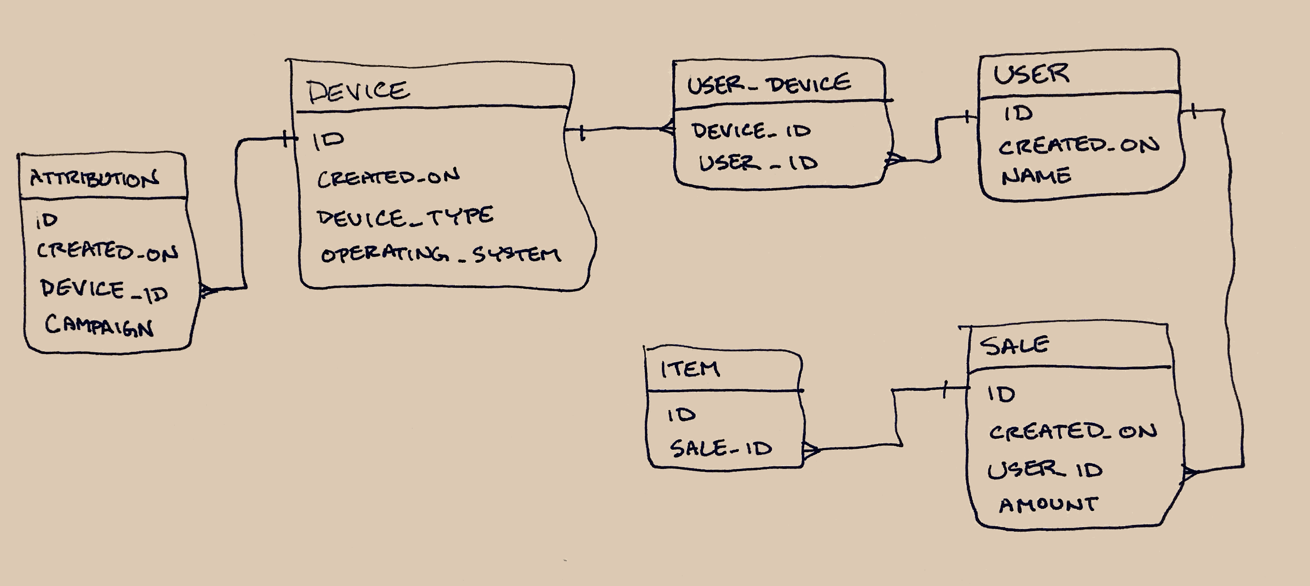

In [1]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandasql import sqldf


%matplotlib inline

In [2]:
attribution = pd.read_csv("attribution.csv")
device = pd.read_csv("device.csv")
item = pd.read_csv("item.csv")
sale = pd.read_csv("sale.csv")
user = pd.read_csv("user.csv")
user_device = pd.read_csv("user_device.csv")

# rename columns
attribution.rename(columns={'id': 'attribution_id', 'created_on': 'attribution_created_on'}, inplace=True)
device.rename(columns={'id': 'device_id', 'created_on': 'device_created_on'}, inplace=True)
item.rename(columns={'id': 'item_id'}, inplace=True)
sale.rename(columns={'id': 'sale_id', 'created_on': 'sale_created_on'}, inplace=True)
user.rename(columns={'id':'user_id', 'created_on': 'user_created_on'}, inplace=True)

In [3]:
attribution.head()

,attribution_created_on,campaign,device_id
0,12/27/16 8:51,ZDNTT7,3063
1,12/28/16 8:42,15R3D0,1711
2,2/16/16 13:32,Y59GNL,2604
3,12/25/16 18:26,T8RNOQ,3559
4,12/17/15 3:28,OGMRY2,3915


# Question 1

In [4]:
# Roughly check, count different campaigns
# TOP 5 campaigns
attribution['campaign'].value_counts().head()

FE91LN    77
0837KH    74
5IHLGC    74
ZZGRSM    74
WELZTZ    73
Name: campaign, dtype: int64

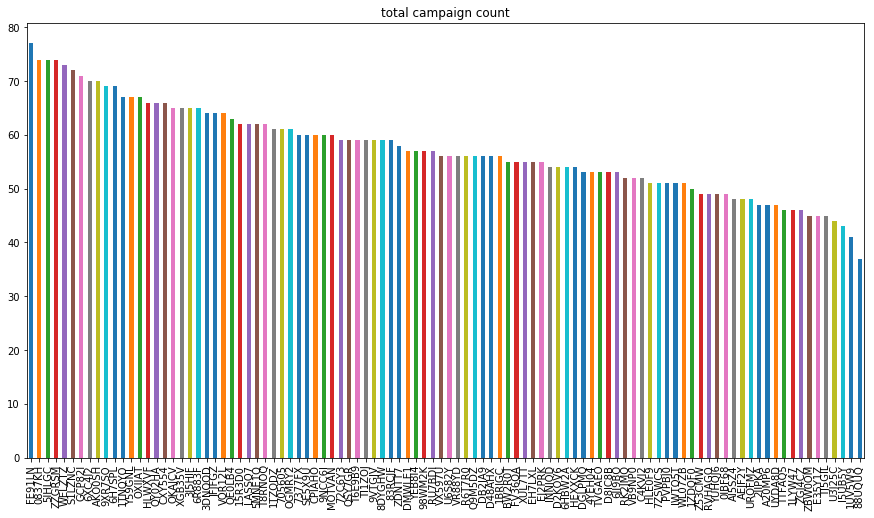

In [5]:
attribution['campaign'].value_counts().plot.bar(figsize=(15, 8), title='total campaign count')

In [6]:
# Do brute left join to gain the big dataset, there're multiple user-device corresponding errors
user_activity = user.merge(user_device, on='user_id', how='left').merge(
    device, on='device_id', how='left').merge(attribution, on='device_id', how='left')

# Change columnes type
user_activity.user_created_on = pd.to_datetime(user_activity.user_created_on)
user_activity.device_created_on = pd.to_datetime(user_activity.device_created_on)
user_activity.attribution_created_on = pd.to_datetime(user_activity.attribution_created_on)
sale.date = pd.to_datetime(sale.date)

user_activity.head()

,user_created_on,user_id,name,device_id,device_created_on,device_type,operating_system,attribution_created_on,campaign
0,2017-02-15 19:39:10.100,0,mufeelm,1,2017-02-15 10:19:43.100,iOS,7,2017-02-15 10:19:00,I5UB5Y
1,2016-05-11 22:44:58.300,1,xjwqwoe,2,2016-05-11 08:09:16.300,iOS,7,NaT,NaN
2,2017-02-06 19:25:48.100,2,cvgpmcv,3,2017-02-06 04:40:31.100,iOS,8,2017-02-06 04:40:00,9VTGJV
3,2017-02-06 19:25:48.100,2,cvgpmcv,4,2016-09-22 06:29:17.200,Android,KitKat,2016-09-22 06:28:00,VR88YD
4,2016-09-22 22:25:50.200,2,jmhkmma,3,2017-02-06 04:40:31.100,iOS,8,2017-02-06 04:40:00,9VTGJV


In [7]:
# Simple Method, just filter by [attribution_created_on, user_created_on]

simple_user_activity = user_activity[user_activity['user_created_on'] - user_activity['attribution_created_on'] > timedelta(0)]

simple_user_activity = simple_user_activity.groupby(['user_created_on', 'name']).apply(
    lambda x: x.sort_values('attribution_created_on').head(1))

# TOP 5 campaigns
simple_user_activity.campaign.value_counts().head()

5IHLGC    44
Y59GNL    41
1BRIGC    38
FE91LN    37
WELZTZ    36
Name: campaign, dtype: int64

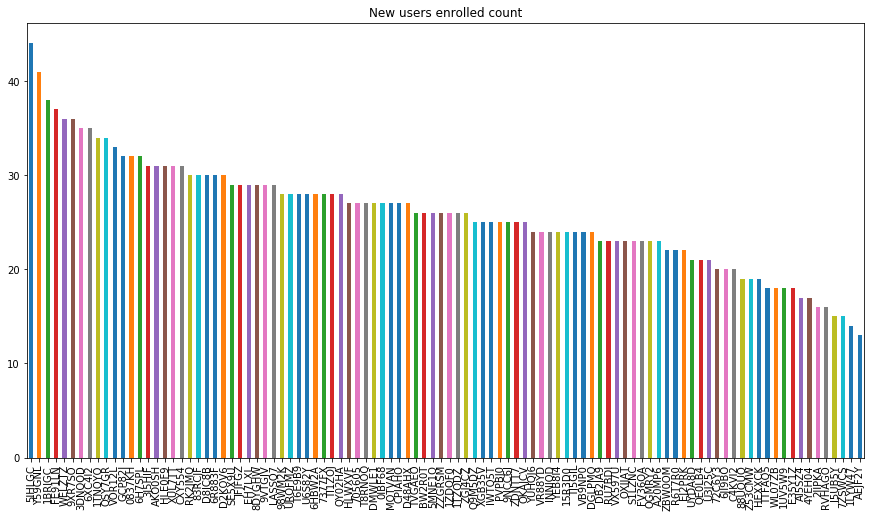

In [8]:
simple_user_activity.campaign.value_counts().plot.bar(figsize=(15, 8), title='New users enrolled count')

# Assumption: 

- Campaigns information sent as soon as campaign id created.

- Workflow: campaign id created by merchant -> campaign info set to users -> device id created by users clicks -> user id created by users sign up.

- Since we are looking into the new users enrolled by campaigns, [attribution_created_on, device_created_on, user_created_on] happends in order and within a specific time period. 

- For each stage, the available time period is 7 days.


In [9]:
# Define filters by create time
user_device_filter = ((user_activity['user_created_on'] - user_activity['device_created_on']) < timedelta(7)) & (
    (user_activity['user_created_on'] - user_activity['device_created_on']) >= timedelta(0))
device_campaign_filter = ((user_activity['device_created_on'] - user_activity['attribution_created_on']) < timedelta(7)) & (
    (user_activity['device_created_on'] - user_activity['attribution_created_on']) >= timedelta(0))

filtered_user_activity = user_activity[user_device_filter & device_campaign_filter]
filtered_user_activity.shape

(2147, 9)

Current dataframe

- user_id can't identify a user, we choose user_created_on & name inseatd, i.e. user_id = 2.
- One unique user may involve in multiple campaigns, choose the earliest one, i.e. user_id = 32.
- There're nan values in campaign column, while unncessary to drop.

In [10]:
filtered_user_activity = filtered_user_activity.groupby(['user_created_on', 'name']).apply(
    lambda x: x.sort_values('attribution_created_on').head(1))

The TOP 5 campains are all different from TOP 5 in roughly check.

In [11]:
filtered_user_activity.campaign.value_counts().head()

5IHLGC    35
9VTGJV    33
6H7SPL    32
6XC4I2    31
CPIAHO    30
Name: campaign, dtype: int64

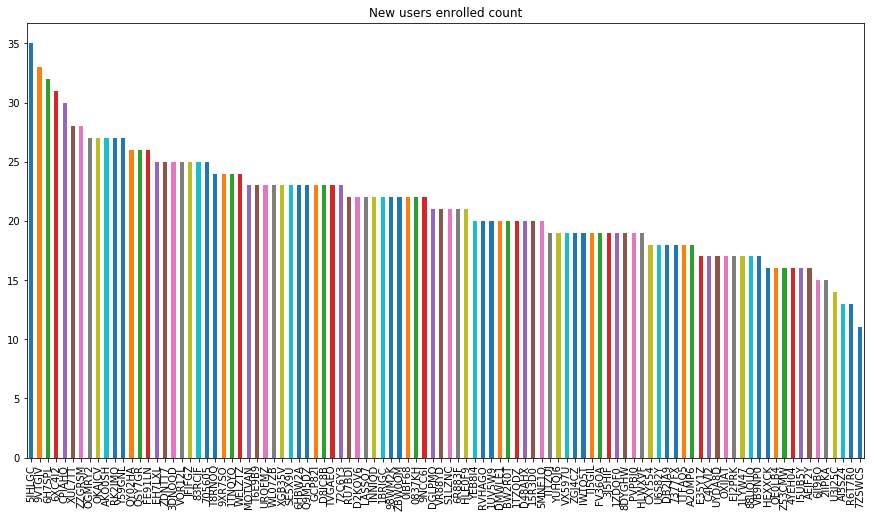

In [12]:
filtered_user_activity.campaign.value_counts().plot.bar(figsize=(15, 8), title='New users enrolled count')

Set the time period as 1 day(short term) and 30 days(long term)

In [13]:
# Short term
short_term_device_filter = ((user_activity['user_created_on'] - user_activity['device_created_on']) < timedelta(1)) & (
    (user_activity['user_created_on'] - user_activity['device_created_on']) >= timedelta(0))
short_term_campaign_filter = ((user_activity['device_created_on'] - user_activity['attribution_created_on']) < timedelta(1)) & (
    (user_activity['device_created_on'] - user_activity['attribution_created_on']) >= timedelta(0))

short_term_user_activity = user_activity[short_term_device_filter & short_term_campaign_filter]
short_term_user_activity = short_term_user_activity.groupby(['user_created_on', 'name']).apply(
    lambda x: x.sort_values('attribution_created_on').head(1))

short_term_user_activity.campaign.value_counts().head()

5IHLGC    34
6H7SPL    32
9VTGJV    32
CPIAHO    30
6XC4I2    30
Name: campaign, dtype: int64

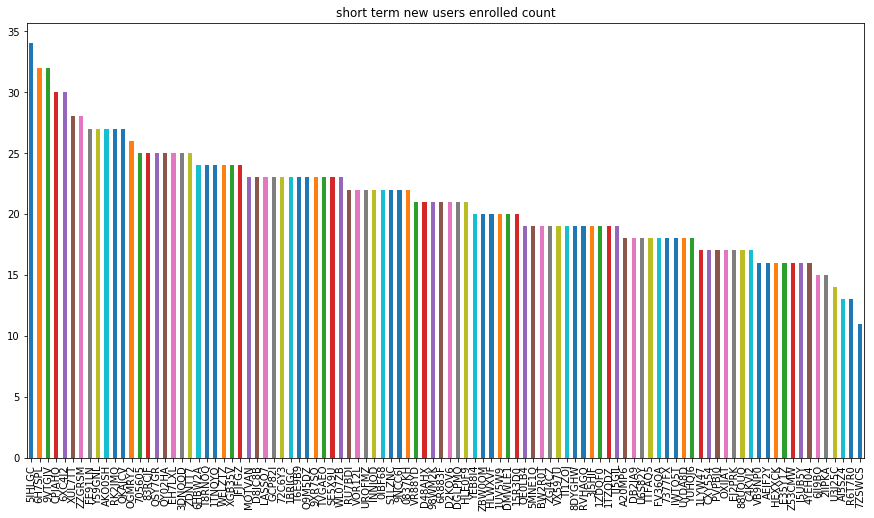

In [14]:
short_term_user_activity.campaign.value_counts().plot.bar(figsize=(15, 8), title='short term new users enrolled count')

In [15]:
# Long term
long_term_device_filter = ((user_activity['user_created_on'] - user_activity['device_created_on']) < timedelta(30)) & (
    (user_activity['user_created_on'] - user_activity['device_created_on']) >= timedelta(0))
long_term_campaign_filter = ((user_activity['device_created_on'] - user_activity['attribution_created_on']) < timedelta(30)) & (
    (user_activity['device_created_on'] - user_activity['attribution_created_on']) >= timedelta(0))

long_term_user_activity = user_activity[long_term_device_filter & long_term_campaign_filter]
long_term_user_activity = long_term_user_activity.groupby(['user_created_on', 'name']).apply(
    lambda x: x.sort_values('attribution_created_on').head(1))

long_term_user_activity.campaign.value_counts().head()

5IHLGC    36
9VTGJV    33
6H7SPL    32
6XC4I2    30
CPIAHO    30
Name: campaign, dtype: int64

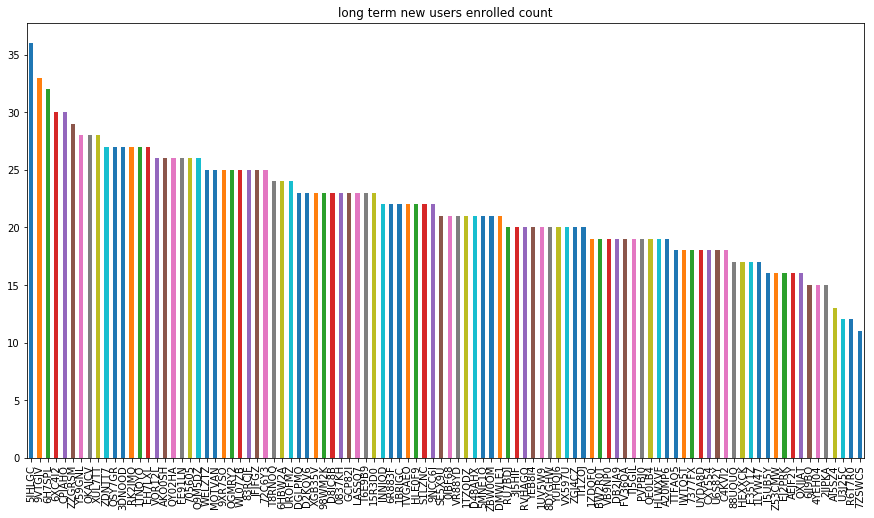

In [16]:
long_term_user_activity.campaign.value_counts().plot.bar(figsize=(15, 8), title='long term new users enrolled count')

# Question 2

In [17]:
sale.head()

# NOTE: the last date is 2017-02-26, which is not a full week or month, all the sale amount/sale volume here are averaged by day

,amount,sale_created_on,user_id,sale_id,date,weekday
0,2361.618399,2013-11-05 14:33:57,3219,0,2013-11-05,1
1,215.867166,2013-11-18 12:23:39,144,1,2013-11-18,0
2,502.872184,2013-11-20 23:40:01,2884,2,2013-11-20,2
3,2316.966268,2013-11-22 15:37:31,2155,3,2013-11-22,4
4,1243.262477,2013-11-24 12:33:27,2155,4,2013-11-24,6


[Text(0.5,1,'daily sale amount per month')]

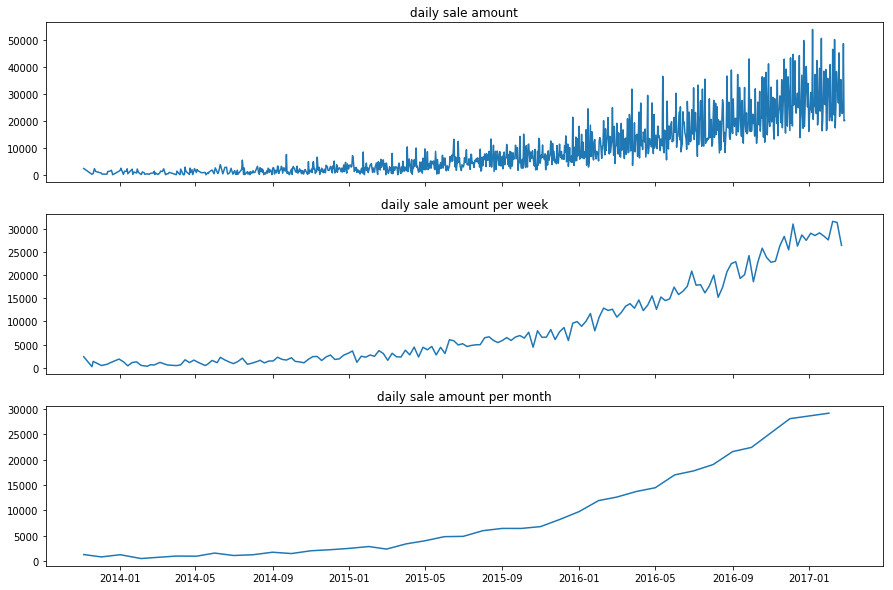

In [18]:
# Total sale amount by date
total_sale = sale.groupby('date')[['amount']].agg([np.sum, len])
total_sale.columns = ['amount', 'volume']

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10), sharex=True)
ax1.plot(total_sale.amount)
ax1.set(title='daily sale amount')

# Add columns [year, month, week]
total_sale['year'] = total_sale.index.year
total_sale['month'] = total_sale.index.month
total_sale['week'] = total_sale.reset_index().date.apply(lambda x: int((x - datetime(2013, 11, 5)).days / 7)).values

# Group by week & month
ax2.plot(total_sale.reset_index().groupby('week')['date'].head(1).values,
         total_sale.groupby('week')[['amount']].mean().reset_index(drop=True).values)
ax2.set(title='daily sale amount per week')

ax3.plot(total_sale.reset_index().groupby(['year', 'month'])['date'].head(1).values,
         total_sale.groupby(['year', 'month'])[['amount']].mean().reset_index(drop=True).values)
ax3.set(title='daily sale amount per month')

According to the weekly & monthly plots, we can easily find there's drop recently. Here we use weekly sale amount data to build ARIMA model to check if the drop is expected.

In [19]:
from statsmodels.tsa.arima_model import ARIMA

weekly_sale_amount = total_sale.groupby('week')[['amount']].mean().reset_index(drop=True).values

model = ARIMA(weekly_sale_amount, order=(1, 1, 1))
model_fit = model.fit(disp=False)
predict_value = model_fit.predict(1, len(weekly_sale_amount), typ='levels')

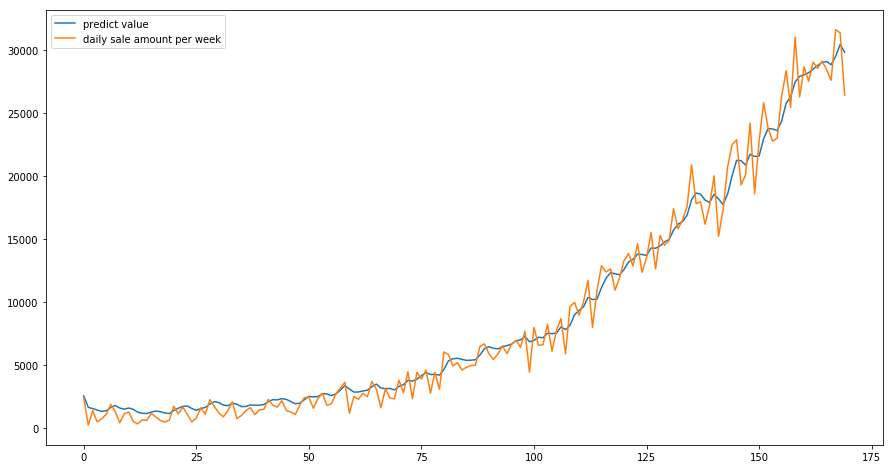

In [20]:
# Model Prediction Visualizaion
f, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot(predict_value)

ax.plot(weekly_sale_amount)
ax.legend(['predict value', 'daily sale amount per week'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000167FBA53320>]],
      dtype=object)

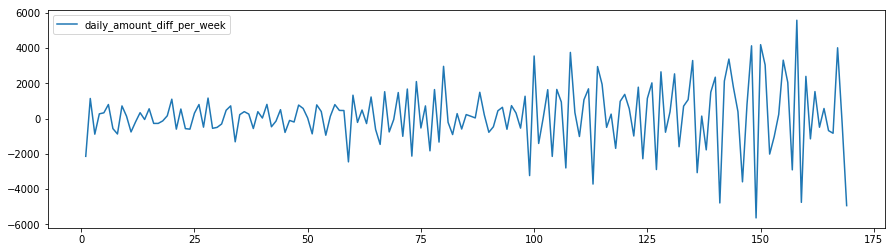

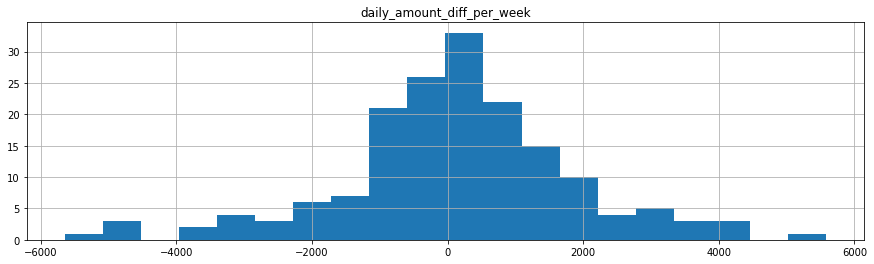

In [21]:
# Other way to test

weekly_sale_amount_diff = total_sale.groupby('week')[['amount']].mean().reset_index(drop=True).diff().rename(columns={'amount': 'daily_amount_diff_per_week'})
weekly_sale_amount_diff.plot(figsize=(15, 4))
weekly_sale_amount_diff.hist(figsize=(15, 4), bins=20)

In [22]:
# Empirical Normal Distribution

mu, sigma = *weekly_sale_amount_diff.mean().values, *weekly_sale_amount_diff.std().values

# 95% confidence interval 
left, right = mu - 2 * sigma, mu + 2 * sigma

print("The 95% confidence interval is [{}, {}], while last drop value is {}.".format(left, right, *weekly_sale_amount_diff.values[-1]))
print("Comparing to previous week, the last week's daily sale amount dropped about {}%.".format(
    round(*((weekly_sale_amount[-2] - weekly_sale_amount[-1]) / weekly_sale_amount[-2]  * 100), 2)))

The 95% confidence interval is [-3348.190508525964, 3632.8102143132674], while last drop value is -4942.9995453531665.
Comparing to previous week, the last week's daily sale amount dropped about 15.76%.


# Drop Detection 

- Industry 
- SaleAmount location distribution
- Special Event
- SaleAmount = SaleVolume * AveragePrice

[Text(0.5,1,'daily sale ave_price per month')]

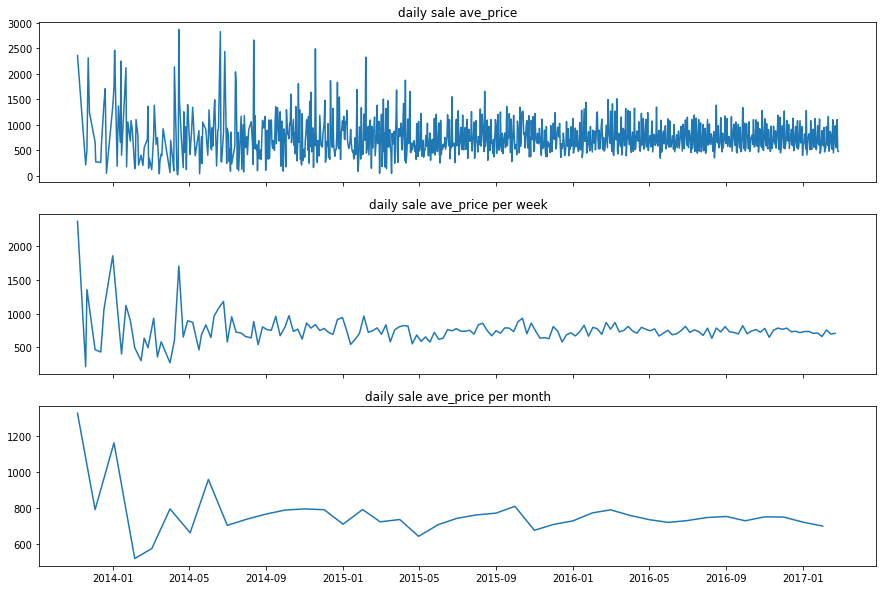

In [23]:
# Average Price Visualiztion

total_sale['ave_price'] = total_sale.amount / total_sale.volume

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10), sharex=True)
ax1.plot(total_sale.ave_price)
ax1.set(title='daily sale ave_price')

# Group by week & month
ax2.plot(total_sale.reset_index().groupby('week')['date'].head(1).values,
         total_sale.groupby('week')[['ave_price']].mean().reset_index(drop=True).values)
ax2.set(title='daily sale ave_price per week')

ax3.plot(total_sale.reset_index().groupby(['year', 'month'])['date'].head(1).values,
         total_sale.groupby(['year', 'month'])[['ave_price']].mean().reset_index(drop=True).values)
ax3.set(title='daily sale ave_price per month')

In [24]:
# Last two weeks daily ave_price
total_sale.groupby('week')[['ave_price']].mean().reset_index(drop=True).values[-2:]

array([[698.61518788],
       [707.02677704]])

[Text(0.5,1,'daily sale volume per month')]

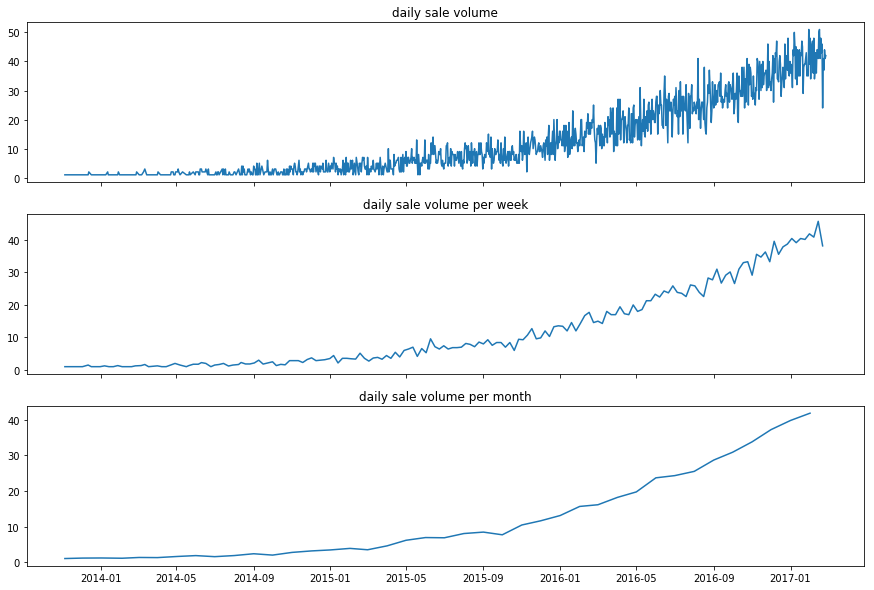

In [25]:
# Sale Volume Visualiztion
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10), sharex=True)
ax1.plot(total_sale.volume)
ax1.set(title='daily sale volume')

# Group by week & month
ax2.plot(total_sale.reset_index().groupby('week')['date'].head(1).values,
         total_sale.groupby('week')[['volume']].mean().reset_index(drop=True).values)
ax2.set(title='daily sale volume per week')

ax3.plot(total_sale.reset_index().groupby(['year', 'month'])['date'].head(1).values,
         total_sale.groupby(['year', 'month'])[['volume']].mean().reset_index(drop=True).values)
ax3.set(title='daily sale volume per month')

In [26]:
attribution['date'] = pd.to_datetime(attribution.attribution_created_on).apply(lambda x: datetime(x.year, x.month, x.day))
filtered_user_activity.user_created_on = pd.to_datetime(filtered_user_activity.user_created_on).apply(lambda x: datetime(x.year, x.month, x.day))
user['date'] = pd.to_datetime(user.user_created_on).apply(lambda x: datetime(x.year, x.month, x.day))

# Define generic function to calculate convertion rate
def cal_convertion_rate(period):    
    
    # assmue user have 7 more days available to purchase itemm after a campaign
    react_period = [period[0] - timedelta(x) for x in range(7, 0, -1)] + period
    campaign = attribution[attribution.date.isin(react_period)].merge(
        user_device, on='device_id', how='left').merge(user, on='user_id', how='left')

    # Rate of click campaigns as user inseatd of guest, only user can make purchase, # campaign_user_id / # campaign_device_id
    convertion_rate = campaign.user_id.count() / campaign.device_id.count()
    
    # Rate of new user enrolled by campaign, # new user enrolled by campaign / # clicks by device
    new_user = filtered_user_activity[filtered_user_activity.user_created_on.isin(period)].user_id
    new_convertion_rate = new_user.count() / (new_user.count() + campaign.user_id.isna().sum())
    
    # Fraction of new users by compaigns of total new users. # new user enrolled by campaign / # total new user
    new_user_by_campaign = new_user.count() / user.date.isin(period).sum()
    
    # Rate of users make purchase by campaigns, which is successful convertion, # sale by campaign / # campaign_user_id
    user_purchase = sale[sale.date.isin(period)].user_id
    user_campaign_purchase = set(user_purchase) & set(campaign.user_id)
    success_convertion_rate = user_purchase[user_purchase.isin(user_campaign_purchase)].count() / campaign.user_id.count()
    
    # Fraction of purchase caused by campains, # sale by campaign / # sale
    purchase_by_campaign = user_purchase[user_purchase.isin(user_campaign_purchase)].count() / user_purchase.count()
    
    return convertion_rate, new_convertion_rate, new_user_by_campaign, success_convertion_rate, purchase_by_campaign

# Break down total volume into different parts
def break_down_count(period):
    
    # assmue user have 7 more days available to purchase itemm after a campaign
    react_period = [period[0] - timedelta(x) for x in range(7, 0, -1)] + period
    
    # daily average sale volume 
    total_sale_volume = total_sale[total_sale.index.isin(period)].volume.mean()
    
    # daily average sale volume by campaign
    campaign = attribution[attribution.date.isin(react_period)].merge(
        user_device, on='device_id', how='left').merge(user, on='user_id', how='left')
    user_purchase = sale[sale.date.isin(period)].user_id
    user_campaign_purchase = set(user_purchase) & set(campaign.user_id)
    sale_volume_by_campaign = user_purchase[user_purchase.isin(user_campaign_purchase)].count() / len(period)
    
    return total_sale_volume, sale_volume_by_campaign

In [32]:
last_week = total_sale[total_sale.week==172].index.tolist()
last_biweek = total_sale[total_sale.week.isin([172, 171])].index.tolist()
last_month = total_sale[total_sale.week.isin([172, 171, 170, 169])].index.tolist()
last_bimonth = total_sale[total_sale.week.isin(range(165, 173))].index.tolist()
last_quarter = total_sale[total_sale.week.isin(range(157, 173))].index.tolist()
week_list = [last_bimonth[x: x + 7] for x in range(0, len(last_bimonth), 7)]
month_list = [last_quarter[x: x + 28] for x in range(0, len(last_quarter), 28)]
# [last_quarter, last_bimonth, last_month, last_biweek, last_week]

# Check out last quarter's metrics by week
metric = pd.DataFrame(columns=['conversion_rate', 'new_conversion_rate', 'new_user_by_campaign', 
                               'success_conversion_rate', 'purchase_by_campaign'])
for time in week_list:
    convertion_rate, new_convertion_rate, new_user_by_campaign, success_convertion_rate, purchase_by_campaign = cal_convertion_rate(time)
    metric = metric.append(
        {'conversion_rate': convertion_rate, 
         'new_conversion_rate': new_convertion_rate,
         'new_user_by_campaign': new_user_by_campaign,
         'success_conversion_rate': success_convertion_rate, 
         'purchase_by_campaign': purchase_by_campaign,}, 
                           ignore_index=True)

# convertion_rate_metric
metric

,conversion_rate,new_conversion_rate,new_user_by_campaign,success_conversion_rate,purchase_by_campaign
0,0.806630,0.539474,0.585714,0.047945,0.024735
1,0.806122,0.479452,0.500000,0.101266,0.058394
2,0.765625,0.457831,0.475000,0.034014,0.017668
3,0.734043,0.390244,0.484848,0.036232,0.017794
4,0.715054,0.376471,0.444444,0.052632,0.023891
5,0.728723,0.378049,0.469697,0.087591,0.041958
6,0.762887,0.452381,0.457831,0.101351,0.046875
7,0.737705,0.351351,0.481481,0.059259,0.034934


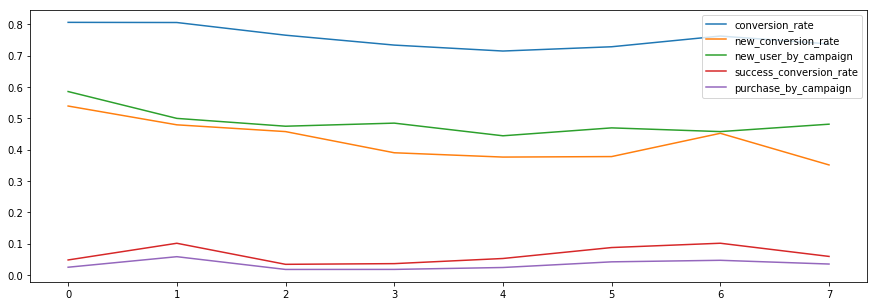

In [33]:
metric.plot(figsize=(15, 5))

In [29]:
# Check each part of sale volume 

fragment = pd.DataFrame(columns=['daily_average_sale_volume', 'daily_average_sale_volume_by_campaign'])
for time in week_list:
    total_sale_volume, sale_volume_by_campaign = break_down_count(time)
    fragment = fragment.append({'daily_average_sale_volume': total_sale_volume, 
                            'daily_average_sale_volume_by_campaign': sale_volume_by_campaign}, 
                           ignore_index=True)
    
fragment["daily_average_sale_volume_not_by_campaign"] = fragment.daily_average_sale_volume - fragment.daily_average_sale_volume_by_campaign
fragment

,daily_average_sale_volume,daily_average_sale_volume_by_campaign,daily_average_sale_volume_not_by_campaign
0,40.428571,1.000000,39.428571
1,39.142857,2.285714,36.857143
2,40.428571,0.714286,39.714286
3,40.142857,0.714286,39.428571
4,41.857143,1.000000,40.857143
5,40.857143,1.714286,39.142857
6,45.714286,2.142857,43.571429
7,38.166667,1.333333,36.833333


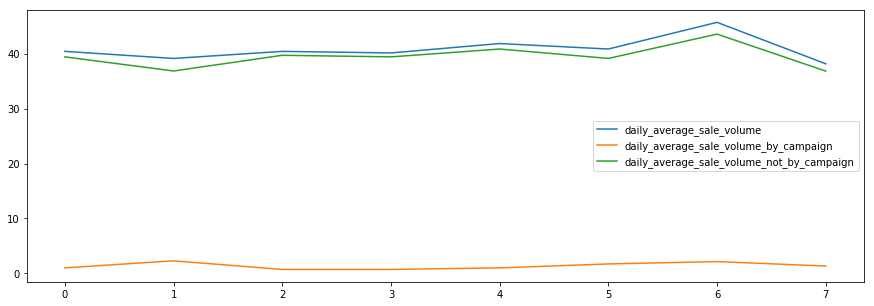

In [30]:
fragment.plot(figsize=(15, 5))

In [31]:
print("Comparing to previous week, the last week's daily sale volume dropped about {}%.".format(
    round((45.714286 - 38.166667) / 45.714286 * 100, 2)))

Comparing to previous week, the last week's daily sale volume dropped about 16.51%.


# Conclustion

- According to the analysis above, the root reason should be the drop of sale volume, especially sale volume not created by campaigns - churn rate.
- Campaigns play important role in new user enrollment(50%), while not in purchase.
- TODO: break down the sale volume into different items, find out which item sale volume dropped most.